In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = '-1'

import sys

from importlib import reload

import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)s | %(name)s | %(levelname)s : %(message)s',
    level=logging.INFO,
    stream=sys.stdout
)

logger = logging.getLogger('hysped')
logger.setLevel(logging.DEBUG)

import contextily as ctx
import geocube
import geopandas as gpd
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import re
import seaborn as sns
import shapely
import tensorflow as tf
import zipfile

import wandb
wandb.login()

from functools import partial
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata, rasterize_points_radial
from IPython.display import JSON, HTML
from keras.utils.np_utils import to_categorical
from matplotlib.colors import to_rgba
from shapely.geometry import box, mapping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
from tqdm.notebook import trange, tqdm
from wandb.keras import WandbMetricsLogger, WandbEvalCallback


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # configure utilization of GPUs
    try:
        for gpu in gpus:
            # memory growth setting
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.set_logical_device_configuration(
                gpu,
                [tf.config.LogicalDeviceConfiguration(memory_limit=256)]
            )
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        module_logger.error(e)


# Make numpy values easier to read.
np.set_printoptions(precision=6, suppress=True)

%matplotlib inline

wandb: Currently logged in as: stevo (hysped). Use `wandb login --relogin` to force relogin


In [2]:
cfg = dict(
    crs = 'EPSG:5514',
    figsize = (12,12),
    data_dir = os.path.join('..', 'data'),
    data = 'Sverepec_spolu.zip',
    data_sampling = True
)
display(JSON(cfg))

<IPython.core.display.JSON object>

In [3]:
def split_df(df:pd.DataFrame, split:float=0.7) -> pd.DataFrame:
    rows = df.shape[0]
    at = int(split * rows)
    return df[:at], df[at:]

def nsplit_df(df:pd.DataFrame, splits:[float]=[0.7]) -> pd.DataFrame:
    rows = df.shape[0]
    df_splits = []
    beg = 0
    for split in splits:
        at = int(split * rows)
        df_splits.append(df[beg:at])
        beg = at
    df_splits.append(df[beg:])
    return df_splits

def predict_model(m, X, Y, label_encoder):
    Y_pred = m.predict(X)
    Y_pred = np.argmax(Y_pred, axis=1)
    Y_pred = label_encoder.inverse_transform(Y_pred)
    Y_pred = pd.DataFrame(Y_pred, columns=['Y_pred'])
    return Y_pred

def print_cm(ax, cm, labels, title='Confusion Matrix'):
    sns.heatmap(
        cm,
        annot=True,
        fmt='g',
        ax=ax,
        cmap='Blues',
        # square=True,
        xticklabels=labels,
        yticklabels=labels,
        linewidths=1,
        # annot_kws={'size': 12}
    )

    ax.set_title(title)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')

    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    
def print_hist(df: pd.DataFrame, col_name='DRUH_DR', stat='count', title=None):
    g = sns.histplot(df[col_name], stat=stat)
    g.xaxis.set_major_locator(mticker.FixedLocator(g.get_xticks()))
    g.set_xticklabels(g.get_xticklabels(), rotation=90)
    if title != None:
        plt.title(title)
    plt.tight_layout()
    plt.show()

# Preprocess data

## Load

,b1_12_10_2,b2_12_10_2,b3_12_10_2,b4_12_10_2,b5_12_10_2,b6_12_10_2,b7_12_10_2,b8_12_10_2,b9_12_10_2,b10_12_10_,...,b178_12_10,b179_12_10,b180_12_10,b181_12_10,b182_12_10,b183_12_10,b184_12_10,b185_12_10,b186_12_10,DRUH_DR
0,0.002312,0.002194,0.002344,0.002613,0.002497,0.002717,0.002706,0.002898,0.002586,0.003052,...,0.046049,0.043585,0.043107,0.045929,0.051554,0.052172,0.054623,0.054570,0.054656,CR
1,0.002277,0.002337,0.002361,0.002488,0.002334,0.002713,0.002796,0.002779,0.002748,0.003034,...,0.042515,0.040856,0.039885,0.043333,0.047781,0.048725,0.047153,0.050167,0.052182,CR
2,0.002243,0.002479,0.002402,0.002322,0.002627,0.002943,0.002809,0.002854,0.002725,0.003096,...,0.044127,0.042798,0.042160,0.042548,0.048506,0.049747,0.050620,0.051325,0.054525,CR
3,0.001883,0.002045,0.002057,0.001970,0.002191,0.002052,0.002102,0.001991,0.001920,0.002308,...,0.035453,0.032728,0.033034,0.034035,0.037514,0.040421,0.040852,0.040839,0.042109,CR
4,0.002193,0.001915,0.002164,0.002090,0.002031,0.002108,0.002084,0.002123,0.001950,0.002291,...,0.026016,0.025324,0.024879,0.026462,0.029662,0.030414,0.031456,0.031279,0.032800,CR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33715,0.002469,0.002863,0.003135,0.003027,0.003056,0.003230,0.003328,0.003523,0.003396,0.003746,...,0.029615,0.028368,0.026700,0.027315,0.031556,0.033276,0.032708,0.033844,0.033287,BR
33716,0.001235,0.000966,0.000953,0.001050,0.000891,0.001143,0.000930,0.001075,0.000944,0.001074,...,0.006762,0.007508,0.006300,0.007368,0.007559,0.008111,0.009299,0.008149,0.008633,BR
33717,0.001709,0.001565,0.001225,0.001534,0.001722,0.002060,0.001738,0.001615,0.001751,0.002011,...,0.026855,0.025384,0.025439,0.025496,0.027390,0.029442,0.033317,0.032171,0.032443,BR
33718,0.001823,0.001716,0.001534,0.001772,0.001997,0.002358,0.002048,0.001988,0.001989,0.002377,...,0.029279,0.027654,0.027549,0.027910,0.030475,0.032133,0.035963,0.035193,0.035305,BR


,b1_12_10_2,b2_12_10_2,b3_12_10_2,b4_12_10_2,b5_12_10_2,b6_12_10_2,b7_12_10_2,b8_12_10_2,b9_12_10_2,b10_12_10_,...,b177_12_10,b178_12_10,b179_12_10,b180_12_10,b181_12_10,b182_12_10,b183_12_10,b184_12_10,b185_12_10,b186_12_10
count,33720.000000,33720.000000,33720.000000,33720.000000,33720.000000,33720.000000,33720.000000,33720.000000,33720.000000,33720.000000,...,33720.000000,33720.000000,33720.000000,33720.000000,33720.000000,33720.000000,33720.000000,33720.000000,33720.000000,33720.000000
mean,0.002247,0.002304,0.002430,0.002565,0.002615,0.002691,0.002687,0.002638,0.002487,0.002943,...,0.024226,0.029662,0.028207,0.027531,0.029403,0.031902,0.033641,0.034560,0.035118,0.035639
std,0.000882,0.000927,0.000999,0.001066,0.001103,0.001149,0.001161,0.001158,0.001098,0.001331,...,0.014980,0.018450,0.017572,0.017085,0.018232,0.019761,0.020832,0.021402,0.021732,0.022028
min,0.000369,0.000332,0.000345,0.000441,0.000444,0.000410,0.000456,0.000441,0.000372,0.000461,...,0.000646,0.000580,0.000697,0.000635,0.000652,0.000638,0.000869,0.000687,0.001013,0.000771
25%,0.001588,0.001611,0.001675,0.001761,0.001775,0.001806,0.001789,0.001735,0.001632,0.001898,...,0.011574,0.014084,0.013299,0.013060,0.013952,0.015179,0.016041,0.016421,0.016770,0.016946
50%,0.002207,0.002261,0.002381,0.002520,0.002568,0.002650,0.002657,0.002603,0.002462,0.002909,...,0.022414,0.027441,0.026038,0.025482,0.027207,0.029539,0.031093,0.031970,0.032546,0.033004
75%,0.002824,0.002898,0.003079,0.003261,0.003335,0.003446,0.003457,0.003407,0.003230,0.003837,...,0.036040,0.044239,0.042118,0.041040,0.043859,0.047575,0.050114,0.051479,0.052331,0.053096
max,0.005978,0.006260,0.006729,0.007038,0.007524,0.007449,0.007360,0.007368,0.006909,0.008184,...,0.066931,0.082097,0.078523,0.076033,0.080653,0.085611,0.091917,0.093709,0.094180,0.095604


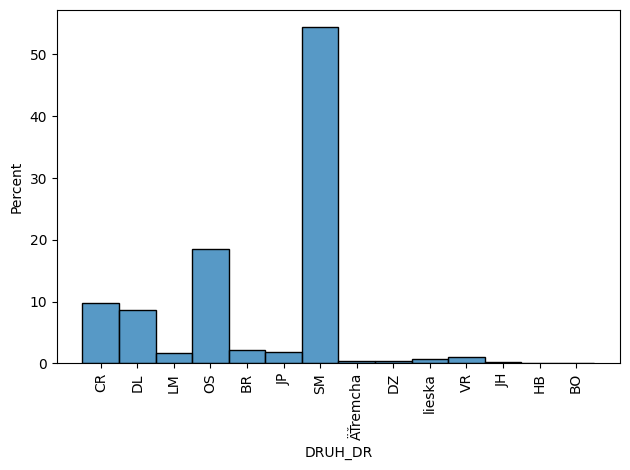

In [4]:
filename = os.path.join(cfg['data_dir'], cfg['data'])
df = pd.read_csv(filename)

display(HTML('<h2>Data preview:</h2>'))
display(df)
display(HTML('<hr>'))
display(HTML('<h2>Data statistics:</h2>'))
display(df.describe())

print_hist(df, stat='percent')

## data sampling

In [5]:
def sample_data(df):
    # remove duplicates
    mask = df.duplicated(keep='first')
    df = df[~mask].copy(deep=True)
    
    # classes counts
    df_hist = df.DRUH_DR.groupby(df.DRUH_DR).count().sort_values(ascending=False)
    # print('%s\n' % df_hist)

    # select the most frequent classes
    selected_classes = df_hist[df_hist > 2500].index.values
    # print('selected_classes: %s\n' % selected_classes)

    # set the rest of the classes to OTHER
    mask = df.DRUH_DR.isin(selected_classes)
    df.loc[~mask,df.DRUH_DR.name] = 'OTHER'
    # print_hist(df)

    # the number of samples for the least frequent class of the most frequent classes
    min_count = df.DRUH_DR.groupby(df.DRUH_DR).count().min()
    # print('min count: %d' % min_count)

    # sample data per class
    df_sampled = pd.DataFrame()
    for class_name in df.DRUH_DR.unique():
        df_class = df[df.DRUH_DR.str.match(class_name)].sample(n=min_count, axis=0)
        df_sampled = pd.concat([df_sampled, df_class])

    return df_sampled

def plot_band_characteristics(df):
    g = sns.FacetGrid(df, col="DRUH_DR", col_wrap=6)
    # plot only features starting with 'b0, b1, ..., b9'
    for col in enumerate(df.columns[df.columns.to_series().str.match(r'^b\d+.*')]):
        gg = g.map(sns.kdeplot, col[1], label=col[1], warn_singular=False)
        gg.set_axis_labels(x_var='')
    # g.add_legend()
    plt.show()

df_sampled = None
if cfg['data_sampling']:
    df_sampled = sample_data(df)

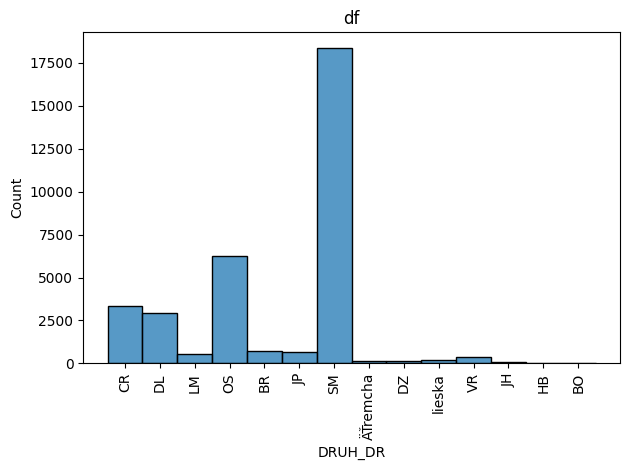

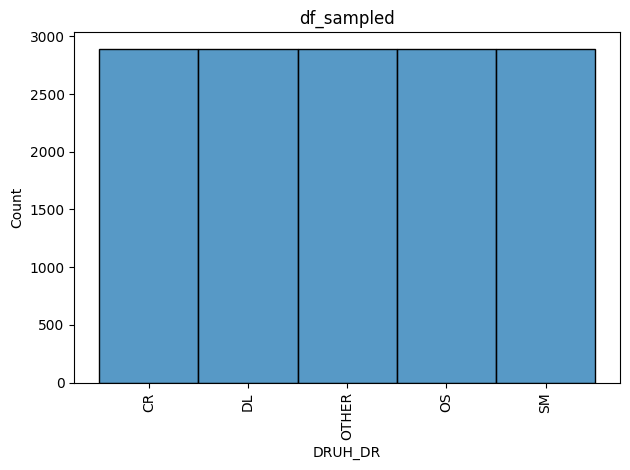

In [6]:
print_hist(df, title='df')
# plot_band_characteristics(df)

if df_sampled is not None:
    print_hist(df_sampled, title='df_sampled')
    # plot_band_characteristics(df_sampled)

In [7]:
df.describe() - df_sampled.describe()

,b1_12_10_2,b2_12_10_2,b3_12_10_2,b4_12_10_2,b5_12_10_2,b6_12_10_2,b7_12_10_2,b8_12_10_2,b9_12_10_2,b10_12_10_,...,b177_12_10,b178_12_10,b179_12_10,b180_12_10,b181_12_10,b182_12_10,b183_12_10,b184_12_10,b185_12_10,b186_12_10
count,19270.000000,19270.000000,19270.000000,19270.000000,19270.000000,19270.000000,19270.000000,19270.000000,19270.000000,19270.000000,...,19270.000000,19270.000000,19270.000000,19270.000000,19270.000000,19270.000000,19270.000000,19270.000000,19270.000000,19270.000000
mean,-0.000332,-0.000348,-0.000374,-0.000396,-0.000414,-0.000429,-0.000430,-0.000429,-0.000403,-0.000484,...,-0.007656,-0.009462,-0.009019,-0.008777,-0.009360,-0.010150,-0.010695,-0.011001,-0.011167,-0.011326
std,-0.000018,-0.000024,-0.000030,-0.000036,-0.000037,-0.000037,-0.000034,-0.000032,-0.000028,-0.000032,...,0.000174,0.000224,0.000211,0.000206,0.000229,0.000255,0.000266,0.000281,0.000277,0.000290
min,-0.000072,-0.000036,-0.000081,0.000000,0.000000,-0.000104,-0.000074,-0.000014,0.000000,-0.000073,...,0.000000,0.000000,-0.000143,-0.000210,0.000000,-0.000262,-0.000122,-0.000169,-0.000150,-0.000475
25%,-0.000381,-0.000392,-0.000431,-0.000448,-0.000475,-0.000506,-0.000508,-0.000503,-0.000472,-0.000574,...,-0.009739,-0.012043,-0.011533,-0.011246,-0.011981,-0.013027,-0.013624,-0.014161,-0.014273,-0.014568
50%,-0.000349,-0.000365,-0.000392,-0.000403,-0.000422,-0.000438,-0.000445,-0.000448,-0.000427,-0.000514,...,-0.011067,-0.013670,-0.013134,-0.012675,-0.013608,-0.014764,-0.015597,-0.015992,-0.016154,-0.016434
75%,-0.000351,-0.000382,-0.000399,-0.000440,-0.000446,-0.000458,-0.000464,-0.000455,-0.000417,-0.000516,...,-0.007500,-0.009298,-0.008814,-0.008576,-0.009124,-0.010005,-0.010524,-0.010810,-0.010906,-0.011109
max,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## prepare data (assuming that the last column is label)

In [8]:
def split_to_train_val(df, frac=0.7, random_state=0):
    df_train = df.sample(frac=frac, axis=0, random_state=random_state)
    df_val = df[~df.index.isin(df_train.index)]
    return df_train, df_val

df_train, df_val = split_to_train_val(
    df_sampled if df_sampled is not None else df
)

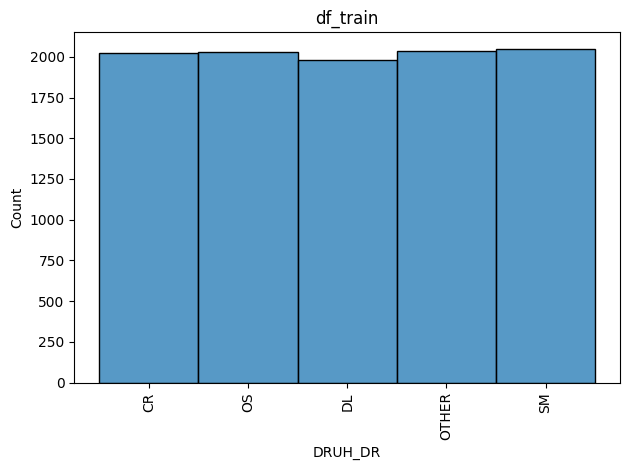

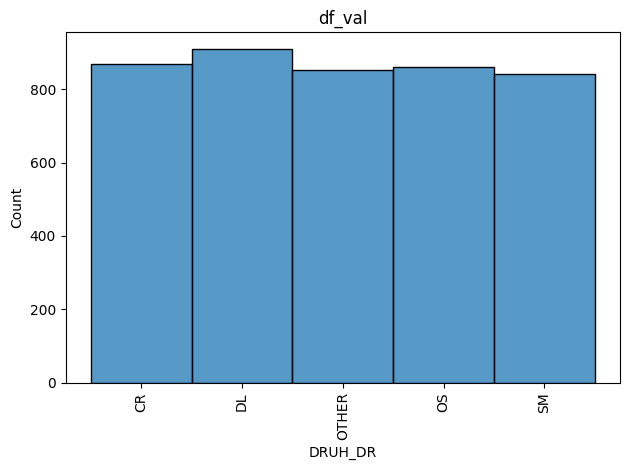

In [9]:
print_hist(df_train, title='df_train')
print_hist(df_val, title='df_val')

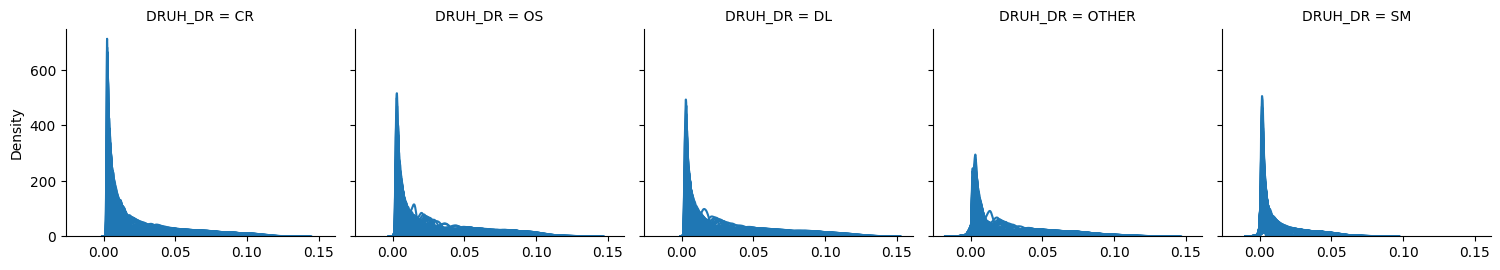

In [10]:
plot_band_characteristics(df_train)

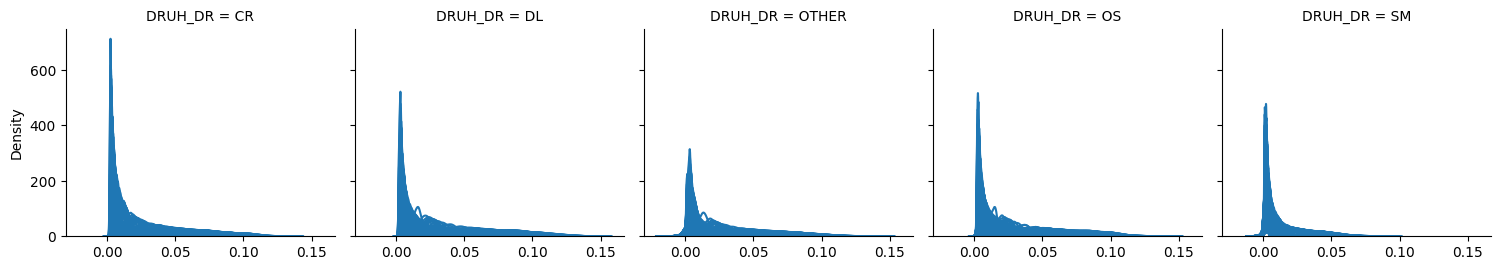

In [11]:
plot_band_characteristics(df_val)

In [12]:
X_train=df_train[df_train.columns[:-1]]
Y_train=df_train[[df_train.columns[-1]]]

num_classes = (df_sampled.DRUH_DR if df_sampled is not None else df.DRUH_DR).unique().shape[0]

label_encoder = LabelEncoder()
label_encoder.fit(
    df_sampled.DRUH_DR if df_sampled is not None else df.DRUH_DR
)

Y_train_1hot = to_categorical(
    label_encoder.transform(Y_train.DRUH_DR),
    num_classes=num_classes
)

In [13]:
X_val=df_val[df_val.columns[:-1]]
Y_val=df_val[[df_val.columns[-1]]]
Y_val_1hot = to_categorical(
    label_encoder.transform(Y_val.DRUH_DR),
    num_classes=num_classes
)

In [14]:
display(X_train)
display(Y_train)
display(Y_train_1hot)

,b1_12_10_2,b2_12_10_2,b3_12_10_2,b4_12_10_2,b5_12_10_2,b6_12_10_2,b7_12_10_2,b8_12_10_2,b9_12_10_2,b10_12_10_,...,b177_12_10,b178_12_10,b179_12_10,b180_12_10,b181_12_10,b182_12_10,b183_12_10,b184_12_10,b185_12_10,b186_12_10
3904,0.002844,0.002806,0.003331,0.003843,0.003388,0.003712,0.003836,0.003699,0.003535,0.004247,...,0.033780,0.041268,0.039844,0.040672,0.041637,0.045355,0.047601,0.046867,0.049453,0.049508
8594,0.001809,0.001948,0.001818,0.001916,0.001949,0.002104,0.002100,0.001996,0.002003,0.002330,...,0.020304,0.024588,0.024367,0.023211,0.024815,0.027992,0.030438,0.030273,0.031533,0.030468
16433,0.002868,0.002948,0.003323,0.003331,0.003497,0.003497,0.003435,0.003483,0.003189,0.003656,...,0.042336,0.051608,0.049161,0.048304,0.051736,0.055712,0.059941,0.058876,0.059775,0.062838
9598,0.001839,0.001713,0.002004,0.001816,0.001856,0.001960,0.001959,0.001759,0.001698,0.001832,...,0.018183,0.024069,0.022102,0.022368,0.023514,0.024776,0.027394,0.026536,0.028833,0.028261
13690,0.003116,0.003487,0.003723,0.003985,0.004221,0.004536,0.004138,0.004441,0.004514,0.004938,...,0.038082,0.046509,0.044905,0.042984,0.046831,0.050702,0.051392,0.055010,0.054443,0.056531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16196,0.004464,0.004363,0.004738,0.005310,0.005252,0.005603,0.005271,0.005306,0.004757,0.005864,...,0.050559,0.062512,0.060697,0.058709,0.062495,0.066725,0.071021,0.072465,0.075788,0.075658
11128,0.001377,0.001512,0.001285,0.001329,0.001705,0.001552,0.001500,0.001399,0.001299,0.001636,...,0.009879,0.012016,0.011664,0.010591,0.012512,0.013239,0.013404,0.014309,0.014398,0.015120
2905,0.002773,0.002868,0.003234,0.003123,0.003252,0.003340,0.003159,0.003341,0.003327,0.003638,...,0.028957,0.036554,0.034584,0.034416,0.034852,0.039445,0.041480,0.041001,0.042871,0.046378
10261,0.003198,0.003040,0.003535,0.003694,0.003972,0.003674,0.003851,0.003775,0.003499,0.004002,...,0.044507,0.055467,0.052283,0.052063,0.054255,0.057881,0.059107,0.063167,0.065200,0.064313


,DRUH_DR
3904,CR
8594,OS
16433,DL
9598,OS
13690,CR
...,...
16196,DL
11128,SM
2905,CR
10261,OS


array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [15]:
display(X_val)
display(Y_val)
display(Y_val_1hot)

,b1_12_10_2,b2_12_10_2,b3_12_10_2,b4_12_10_2,b5_12_10_2,b6_12_10_2,b7_12_10_2,b8_12_10_2,b9_12_10_2,b10_12_10_,...,b177_12_10,b178_12_10,b179_12_10,b180_12_10,b181_12_10,b182_12_10,b183_12_10,b184_12_10,b185_12_10,b186_12_10
11579,0.001953,0.002339,0.002429,0.002438,0.002509,0.002357,0.002480,0.002167,0.002421,0.002626,...,0.025502,0.032809,0.030932,0.029909,0.032576,0.033130,0.035683,0.035006,0.038068,0.038696
12148,0.002504,0.002207,0.002765,0.002705,0.003215,0.002909,0.003087,0.003158,0.002883,0.003503,...,0.040717,0.049716,0.048193,0.046397,0.050030,0.052238,0.055485,0.056661,0.058529,0.061440
13181,0.002519,0.002741,0.003021,0.002986,0.002724,0.003209,0.003157,0.003386,0.002933,0.003359,...,0.031662,0.040090,0.038156,0.036706,0.038806,0.042968,0.045665,0.046671,0.047198,0.047504
387,0.001982,0.001863,0.001731,0.002060,0.002066,0.002052,0.002115,0.002058,0.002078,0.002409,...,0.037580,0.046975,0.042596,0.043434,0.044397,0.049983,0.049547,0.051519,0.053418,0.055136
3315,0.003410,0.003649,0.003249,0.003996,0.003839,0.003812,0.004108,0.003980,0.003624,0.004739,...,0.034828,0.042077,0.039294,0.037779,0.038634,0.045193,0.047256,0.047354,0.047590,0.048701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30283,0.002284,0.002065,0.002449,0.002800,0.002527,0.002758,0.002966,0.002579,0.002579,0.003040,...,0.016799,0.020094,0.020104,0.018915,0.020613,0.022150,0.024502,0.023740,0.023530,0.025244
11011,0.001842,0.002009,0.002310,0.002476,0.002482,0.002455,0.002582,0.002619,0.002383,0.002775,...,0.016695,0.020669,0.019869,0.018769,0.019640,0.022284,0.023808,0.024071,0.023518,0.023685
22401,0.003225,0.003165,0.003614,0.003757,0.003780,0.003964,0.003688,0.003727,0.003505,0.003876,...,0.013386,0.015526,0.015633,0.014668,0.015891,0.017193,0.018253,0.018483,0.018455,0.019429
18960,0.001178,0.001692,0.001552,0.001884,0.001404,0.001714,0.001635,0.001822,0.001491,0.001742,...,0.010730,0.012578,0.012266,0.011981,0.012422,0.013468,0.014134,0.014821,0.014615,0.014701


,DRUH_DR
11579,CR
12148,CR
13181,CR
387,CR
3315,CR
...,...
30283,SM
11011,SM
22401,SM
18960,SM


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [16]:
def make_model(
    input_shape: tuple,
    filters: int,
    kernel_size: int,
    num_classes: int
):
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.Input(
            shape=input_shape
        )
    )
    model.add(
        tf.keras.layers.BatchNormalization()
    )
    for i in range(2):
        model.add(
            tf.keras.layers.Conv1D(
                filters=filters,
                kernel_size=kernel_size,
                activation=tf.nn.relu,
                padding='causal'
            )
        )
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(num_classes * 2))
    model.add(tf.keras.layers.Dense(num_classes))
    model.add(tf.keras.layers.Softmax())
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    return model

In [19]:
project_name = 'hysped-conv1d-relu-proportional-data'

wandb.init(project=project_name)
model = make_model(
    input_shape=(X_train.shape[1], 1),
    filters=32,
    kernel_size=14,
    num_classes=num_classes
)
history = model.fit(
    x=X_train,
    y=Y_train_1hot,
    validation_data=(X_val, Y_val_1hot),
    epochs=50,
    shuffle=True,
    batch_size=8,
    callbacks=[
        WandbMetricsLogger(),
    ],
    verbose=1
)
wandb.finish()

Epoch 1/50
1265/1265 [==============================] - 21s 13ms/step - loss: 0.9871 - categorical_accuracy: 0.5981 - val_loss: 0.8490 - val_categorical_accuracy: 0.6055
Epoch 2/50
1265/1265 [==============================] - 16s 13ms/step - loss: 0.6955 - categorical_accuracy: 0.7375 - val_loss: 0.5919 - val_categorical_accuracy: 0.7977
Epoch 3/50
1265/1265 [==============================] - 16s 13ms/step - loss: 0.6099 - categorical_accuracy: 0.7762 - val_loss: 0.5303 - val_categorical_accuracy: 0.8348
Epoch 4/50
1265/1265 [==============================] - 16s 12ms/step - loss: 0.5567 - categorical_accuracy: 0.7976 - val_loss: 0.5031 - val_categorical_accuracy: 0.8397
Epoch 5/50
1265/1265 [==============================] - 16s 12ms/step - loss: 0.5363 - categorical_accuracy: 0.8068 - val_loss: 0.4556 - val_categorical_accuracy: 0.8473
Epoch 6/50
1265/1265 [==============================] - 16s 13ms/step - loss: 0.5165 - categorical_accuracy: 0.8107 - val_loss: 0.4518 - val_categoric

epoch/categorical_accuracy,▁▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▅▆▆▇▇▇▇▇▇▇▇▇▇▇██▇▇▇█████▇██████▇█████▇▇
epoch/val_loss,█▅▄▄▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▂▁▁▁▁▁▂▁
epoch/categorical_accuracy,0.87632
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.35401
epoch/val_categorical_accuracy,0.89204


136/136 [==============================] - 1s 4ms/step


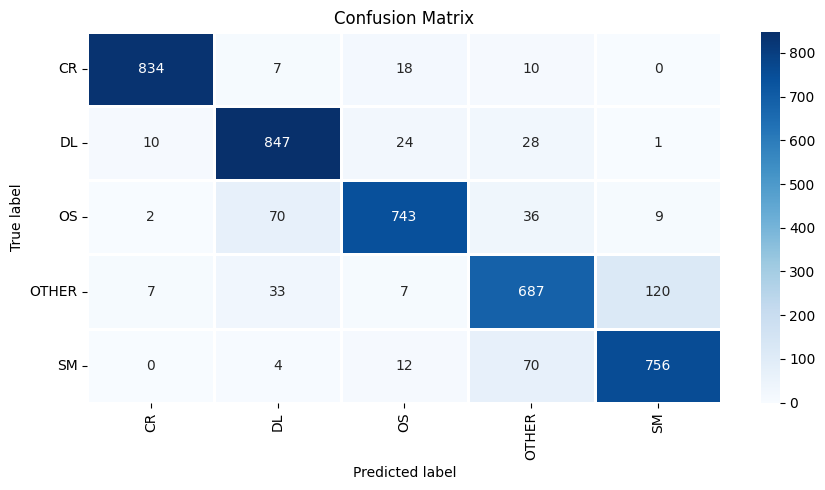

In [20]:
Y_pred = predict_model(model, X_val, Y_val, label_encoder=label_encoder)
cm = confusion_matrix(Y_val, Y_pred)

fig, ax = plt.subplots(figsize=(9,5))
print_cm(ax, cm, labels=label_encoder.classes_)
plt.show()

## hyperparameter tuning

In [ ]:
project_name = 'hysped-conv1d-sweep-relu-proportional-data'

def main():
    wandb.init(project=project_name)
    model = make_model(
        input_shape=(X_train.shape[1], 1),
        filters=wandb.config.filters,
        kernel_size=wandb.config.kernel_size,
        num_classes=num_classes
    )
    history = model.fit(
        x=X_train,
        y=Y_train_1hot,
        epochs=50,
        validation_data=(X_val, Y_val_1hot),
        shuffle=True,
        batch_size=wandb.config.batch_size,
        callbacks=[
            WandbMetricsLogger(),
        ],
        verbose=0
    )
    wandb.log(pd.DataFrame(history.history)[-1:].reset_index(drop=True).to_dict(orient='records')[0])

# Define the search space
sweep_configuration = {
    'method': 'random',
    'metric': {
        'goal': 'maximize',
        'name': 'val_categorical_accuracy'
    },
    'parameters': {
        'kernel_size': {
            'values': [x for x in range(3,17)]
        },
        'filters': {
            'values': [2**x for x in range(4,8)]
        },
        'batch_size': {
            'values': [2**x for x in range(8)]
        }
     }
}

# Start the sweep
sweep_id = wandb.sweep(sweep=sweep_configuration, project=project_name)
wandb.agent(sweep_id, function=main, count=25)
wandb.finish()

Create sweep with ID: x1ykyc05
Sweep URL: https://wandb.ai/hysped/hysped-conv1d-sweep-relu-proportional-data/sweeps/x1ykyc05


wandb: Agent Starting Run: 0bsri4rt with config:
wandb: 	batch_size: 16
wandb: 	filters: 16
wandb: 	kernel_size: 6
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


categorical_accuracy,▁
epoch/categorical_accuracy,▁▄▅▅▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▅▆▆▆▆▆▅▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█████████
epoch/val_loss,█▅▄▄▃▃▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▁▁▁▁
loss,▁
val_categorical_accuracy,▁
val_loss,▁
categorical_accuracy,0.82333


wandb: Agent Starting Run: fgk7lx6e with config:
wandb: 	batch_size: 8
wandb: 	filters: 16
wandb: 	kernel_size: 9
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


categorical_accuracy,▁
epoch/categorical_accuracy,▁▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▃▃▄▄▄▅▅▅▅▆▆▇▆▆▇▆▇▇▇▇▆▇▇▇▇▇▇█▇▇██▇▇▇████
epoch/val_loss,█▆▆▅▅▅▄▄▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
loss,▁
val_categorical_accuracy,▁
val_loss,▁
categorical_accuracy,0.8521


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0s1stqj0 with config:
wandb: 	batch_size: 128
wandb: 	filters: 32
wandb: 	kernel_size: 14
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


categorical_accuracy,▁
epoch/categorical_accuracy,▁▃▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█▇█▇████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▁▁▂▅▇▇▇▇█▇███████▇▇██▇████████████████
epoch/val_loss,▅▆██▅▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,▁
val_categorical_accuracy,▁
val_loss,▁
categorical_accuracy,0.86584


wandb: Agent Starting Run: erwuiutb with config:
wandb: 	batch_size: 2
wandb: 	filters: 16
wandb: 	kernel_size: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
